In [23]:
# import libraries
import h5py
import os
import numpy as np
from cil.framework import AcquisitionGeometry, ImageGeometry
from tqdm import tqdm
from cil.plugins.astra import FBP as FBP_Astra
from cil.plugins.tigre import FBP as FBP_Tigre
import matplotlib.pyplot as plt
import dask
import time

### Load Data using h5

In [6]:
path_to_data = "NMC532_D20_neutronCT.h5"

with h5py.File(path_to_data, "r") as f:
    tmp_data = f["data"][:]

# fix orientation for astra/tigre
tmp_data = np.swapaxes(tmp_data, 2,0)  

# define dimension for the acquisition data
vertical, num_angles, horizontal = tmp_data.shape
print(vertical, num_angles, horizontal)

1546 429 502


### Create acquisition geometry

In [7]:
angles_list = np.linspace(0, 2*np.pi, num_angles)

ag = AcquisitionGeometry.create_Parallel3D().\
        set_panel([horizontal,vertical]).\
        set_angles(angles_list, angle_unit="radian").\
        set_labels(['vertical','angle','horizontal'])

### Allocate space for acquisition data

In [8]:
data = ag.allocate(None)
data.fill(tmp_data)
# data.reorder("astra")

### Define reconstruction space

In [9]:
ig = ag.get_ImageGeometry()

# reduce dimension of reconstruction space
ig.voxel_num_y = 300
ig.voxel_num_x = 300
ig.center_x = 40
ig.center_y = -30

In [35]:
def run_FBP_slices(data, device="cpu", backend="astra", parallel=False):  
    
    ag = data.geometry
    ig = ag.get_ImageGeometry()

    ag2D = ag.get_slice(vertical=0)
    ig2D = ag2D.get_ImageGeometry()    

    data.reorder(backend)
            
    fbp_recon = ig.allocate()

    if parallel==False:
        for i in tqdm(range(ig.shape[0])):
            data2D = data.get_slice(vertical=i)
            if backend=="astra":
                tmp_fbp_2D = FBP_Astra(ig2D, ag2D, device=device)(data2D)
            elif backend=="tigre":
                # will raise a cil/tigre error if device="cpu"???
                tmp_fbp_2D = FBP_Astra(ig2D, ag2D, device=device)(data2D)
            else:
                raise ValueError("Astra/Tigre backends are supported. Got {}".format(backend))
            fbp_recon.fill(tmp_fbp_2D, vertical=i)
    else:
        if device=="gpu":
            raise ValueError("Parallel FBP with gpu is not implemented")
            
        tmp_list = []
        for i in range(ig.shape[0]):
            tmp = data.get_slice(vertical=i)
            if backend=="astra":
                tmp_del = dask.delayed(FBP_Astra(ig2D, ag2D, device=device))(tmp)
            elif backend=="tigre":
                tmp_del = dask.delayed(FBP_Astra(ig2D, ag2D, device=device))(tmp)
            else:
                raise ValueError("Astra/Tigre backends are supported. Got {}".format(backend))            
            tmp_list.append(tmp_del)   

        print("Computing FBP in parallel...")
        t1 = time.time()
        res_list = dask.compute(*tmp_list)
        print("Finish in {} sec".format(time.time() - t1))

        for i in range(ig.shape[0]):
            fbp_recon.fill(res_list[i].array, vertical=i)
        
    return fbp_recon
    


In [43]:
%%time
fbp_recon = run_FBP_slices(data, device="cpu", backend="astra", parallel=False)
# takes about 20 minutes

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1546/1546 [22:43<00:00,  1.13it/s]

CPU times: total: 22min 44s
Wall time: 22min 43s


In [37]:
%%time
fbp_recon = run_FBP_slices(data, device="cpu", backend="astra", parallel=True)


Computing FBP in parallel...
Finish in 77.48575854301453 sec
CPU times: total: 49min 17s
Wall time: 1min 21s


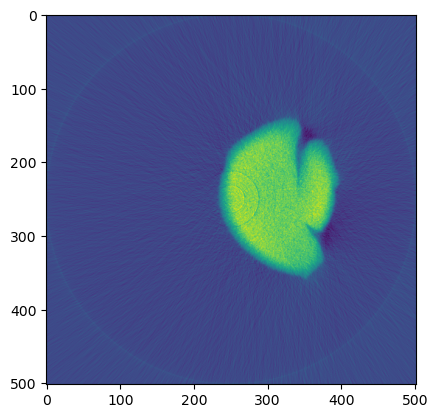

In [44]:
plt.imshow(fbp_recon.array[100])